# Deep Contextual Bandits Script

This notebook shows usage of the SpaceBandits package for deep contextual bandits.

## Toy Problem
Contextual bandits models are difficult to validate due to the nature of the problems they try to solve. The best way to confirm a model converges in practice is to use a toy problem.<br><br>
This notebook has a very simple toy problem. We are dealing with a group of customers. We have two features: Age, and ARPU (some measure of that customer's spend at our company.) There are two groups of customers, which can be seen in the scatterplot below.<br><br>
Our company offers three promotions: the first is best for one group of customers, while the third is best for the other group. The second promotion is not optimal for either customer. As in most real-life situations, a significant number of customers will not make purchases. Contextual bandits models handle this behavior gracefully, as they model the rewards as a stochastic process.

In [1]:
import numpy as np
import pandas as pd
from random import random
import matplotlib.pyplot as plt
##Generate Data

def get_customer(ctype=None):
    """Customers come from two feature distributions.
    Class 1: mean age 25, var 5 years, min age 18
             mean ARPU 100, var 15
    Class 2: mean age 45, var 6 years
             mean ARPU 50, var 25
    """
    if ctype is None:
        if random() > .5: #coin toss
            ctype = 1
        else:
            ctype = 2
    age = 0
    ft = -1
    if ctype == 1:
        while age < 18:
            age = np.random.normal(25, 5)
        while ft < 0:
            ft = np.random.normal(100, 15)
    if ctype == 2:
        while age < 18:
            age = np.random.normal(45, 6)
        while ft < 0:
            ft = np.random.normal(50, 25)
    age = round(age)
    return ctype, (age, ft)

def get_rewards(customer):
    """
    There are three actions:
    promo 1: low value. 10 dollar if accept
    promo 2: mid value. 25 dollar if accept
    promo 3: high value. 100 dollar if accept
    
    Both groups are unlikely to accept promo 2.
    Group 1 is more likely to accept promo 1.
    Group 2 is slightly more likely to accept promo 3.
    
    The optimal choice for group 1 is promo 1; 90% acceptance for
    an expected reward of 9 dollars each.
    Group 2 accepts with 25% rate for expected 2.5 dollar reward
    
    The optimal choice for group 2 is promo 3; 20% acceptance for an expected
    reward of 20 dollars each.
    Group 1 accepts with 2% for expected reward of 2 dollars.
    
    The least optimal choice in all cases is promo 2; 10% acceptance rate for both groups
    for an expected reward of 2.5 dollars.
    """
    if customer[0] == 1: #group 1 customer
        if random() > .1:
            reward1 = 10
        else:
            reward1 = 0
        if random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if random() > .98:
            reward3 = 100
        else:
            reward3 = 0
    if customer[0] == 2: #group 2 customer
        if random() > .75:
            reward1 = 10
        else:
            reward1 = 0
        if random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if random() > .80:
            reward3 = 100
        else:
            reward3 = 0
    return np.array([reward1, reward2, reward3])

def get_cust_reward():
    """returns a customer and reward vector"""
    cust = get_customer()
    reward = get_rewards(cust)
    age = cust[1]
    return np.array([age])/100, reward

## Visualizing the Groups
We can see in our simple toy problem the two groups are visually separable in the feature space.

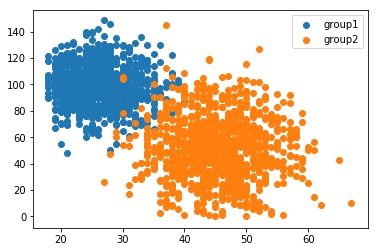

In [2]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1');
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2');
plt.legend()

## Sanity Check: Expected Rewards
To make sure the data-generating functions work well, I randomly sample from both groups of customers and get the average reward from each. This helps me confirm which offers are best for which group.

In [3]:
customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (100000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
rewards.mean(axis=0)
print('group 2 expected rewards: (100000 samples)', rewards.mean(axis=0))

group 1 expected rewards: (100000 samples) [8.9969  2.48025 2.007  ]
group 2 expected rewards: (100000 samples) [ 2.5025   2.52725 19.739  ]


## The Model's Task
The contextual bandit model does not know that there are two customer populations. It has to discover these distributions and characterize their spending behavior simultaneously. This is the nature of the contextual bandits problem, and it's what makes the problem so hard.<br><br>
On a first pass, we'll use a Bayesian linear regression model that directly maps the features to an expected reward via linear coefficients. We'll use "online" learning for this example, meaning the model makes a decision, observes a reward, and repeats.

total regret this round:  1860


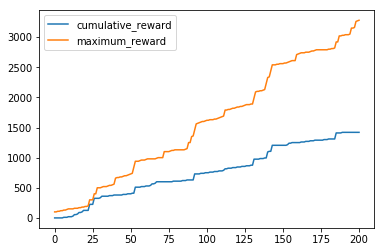

total regret this round:  1200


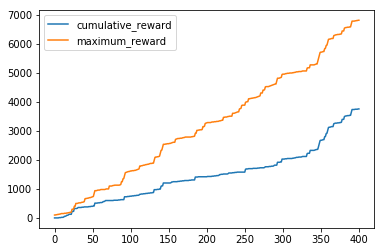

In [4]:
from space_bandits import init_linear_model

num_actions = 3
context_dim = 2

linear_model = init_linear_model(num_actions, context_dim, initial_pulls=100)

def iterate_model(model, steps):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    timesteps = []
    c_reward = []
    cumulative_reward = 0
    m_reward = []
    maximum_reward = 0
    regret_record = []

    for i in range(steps):
        timesteps.append(i)
        #generate a customer
        cust = get_customer()
        #generate customer decisions based on group
        reward_vec = get_rewards(cust)
        #prepare features for model
        context = np.array([cust[1]])/100
        if cust[0] == 1:
            best_choice = 0
        elif cust[0] == 2:
            best_choice = 2
        else:
            raise Exception()
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        maximum_reward += mx
        m_reward.append(maximum_reward)
        action = model.action(context)
        #get reward for the action chosen by model
        reward = reward_vec[action]
        #regret is the opportunity cost of not choosing the optimal promotion
        regret = mx - reward
        regret_record.append(regret)
        cumulative_reward += reward
        c_reward.append(cumulative_reward)
        model.update(context, action, reward)
        #plot occasionally
        if i % 200 == 0 and i > 0:
            print('total regret this round: ', sum(regret_record))
            regret_record = []
            plt.plot(timesteps, c_reward, label='cumulative_reward')
            plt.plot(timesteps, m_reward, label='maximum_reward')
            plt.legend()
            plt.show()
            
iterate_model(linear_model, 500)

## Optimizing
We see high regret early on, but after the model optimizes, regret (maximum reward minus earned reward) drops significantly.

## Saving/Loading
We can save and load models freely and continue learning after re-loading (as is done below). This is important functionality for an online model.

total regret this round:  140


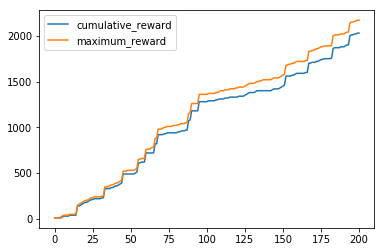

total regret this round:  180


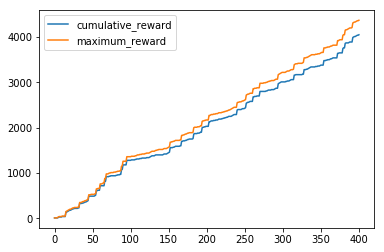

In [5]:
#test linear model saving/loading
from space_bandits import load_linear_model
linear_model.save('test_path.pkl')
linear_model = load_linear_model('test_path.pkl')

#continue training

iterate_model(linear_model, 500)

## Visualizing the Decision Boundary
After converging, the model will recommend a different offer depending on where a given customer appears in the feature space. We can visualize this as a "decision boundary."

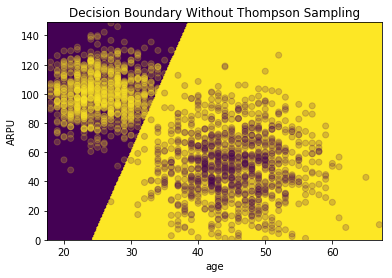

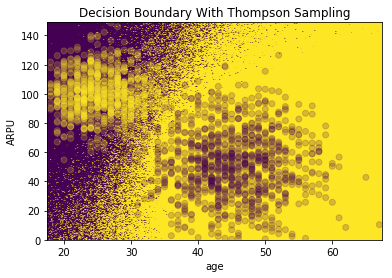

took  228.76017141342163


In [6]:
def plot_decision_boundary(model, X, Y, h=1, scale=100., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    #model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.5)

    # Add the training points to the plot.
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.2);
    #plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.1, thompson=False, title='Decision Boundary Without Thompson Sampling')
t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.1, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', time()-t1)

(Colors are inverted for visual contrast; the purple background is the right choice for the yellow points, and vis versa. Cyan is the second, non-optimal promotion.)

## A Note on Thompson Sampling
As you can see above, the output of the model changes when we apply Thompson Sampling. This is how the model explores: in regions where it is uncertain (say, where the customer groups overlap), Thompson sampling returns a mix of recommendations between the two groups. This allows the model to further optimize with future examples. Thus, Thompson sampling gives us a "smart" way to explore.<br><br> While the model is confused when a customer lies just between the two groups, it can very confidently exclude the "bad" second promotion as an option. However, in regions where very few customers appear, the "bad" promotion is still recommended occasionally, as the model has no reason to think this is a bad choice where there are just too few samples to be sure.

## Neural Network
An extension of this simple model uses a neural network to build more robust features for the linear model. Let's try one such model here.<br><br>
As a default, SpaceBandits implements a single 50-node hidden layer nn model. During training, the model will stop and train its neural network at a specified number of updates (default: every 50 updates.)

Initializing model neural_model-bnn.
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
total regret this round:  1930


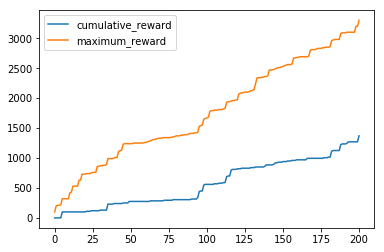

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
total regret this round:  970


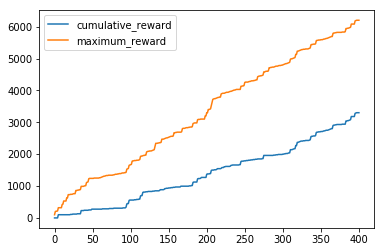

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


In [7]:
from space_bandits import init_neural_model

num_actions = 3
context_dim = 2
memory_size = 1000

neural_model = init_neural_model(num_actions, context_dim, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 5])
assert neural_model.data_h.memory_size == memory_size

iterate_model(neural_model, 500)

## Saving Neural Models
As with linear models, neural models can be saved and re-loaded during training. Because these models include a neural network in Tensorflow, SpaceBandits creates a .zip file to keep everything together. Make sure to append the .zip extension when reloading.

In [8]:
neural_model.save('test_model')
from space_bandits import load_neural_model
neural_model = load_neural_model('test_model.zip')

Initializing model neural_model-bnn.
INFO:tensorflow:Restoring parameters from tmp/weights


Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
total regret this round:  500


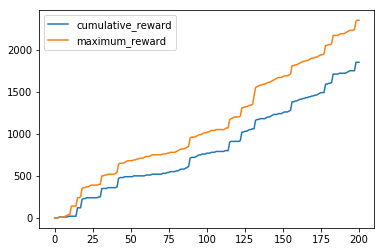

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...
total regret this round:  150


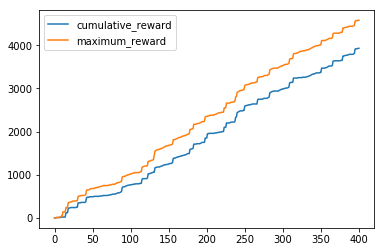

Training neural_model-bnn for 100 steps...
Training neural_model-bnn for 100 steps...


In [9]:
iterate_model(neural_model, 500)

The neural model performs comparably to the linear model in this case; it's valuable for situations where linear decision boundaries are not effective (more general cases).

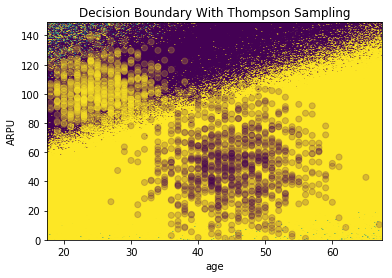

took  526.3281514644623


In [ ]:
t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.1, thompson=True, parallelize=False, title='Decision Boundary With Thompson Sampling')
print('took ', time() - t1)

t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.1, thompson=True, parallelize=True, title='Decision Boundary With Thompson Sampling', n_threads=3)
print('took ', time() - t1)

## Training from Historic Data
Online learning is great, but in practice we can't always see rewards immediately. SpaceBandits provides methods for rapidly training from historic data as well.<br><br>
These methods play nice with online methods; batch training with new calls to .fit will retain information from previous calls to .fit.

In [ ]:
def generate_dataframe(n_rows):
    df = pd.DataFrame()
    ages = []
    ARPUs = []
    actions = []
    rewards = []
    for i in range(n_rows):
        cust = get_customer()
        reward_vec = get_rewards(cust)
        context = np.array([cust[1]])
        ages.append(context[0, 0]/100)
        ARPUs.append(context[0, 1]/100)
        action = np.random.randint(0,3)
        actions.append(action)
        reward = reward_vec[action]
        rewards.append(reward)

    df['age'] = ages
    df['ARPU'] = ARPUs
    df['action'] = actions
    df['reward'] = rewards

    return df

df = generate_dataframe(1000)

df.head()

## Preparing Data for Training
As can be seen above, rows of data must be organized into tripets: features, actions, and rewards. In this case, these records represent a customer (age, ARPU), action (which promotion they saw), and what reward was earned (how much money the customer spent on the promotion.)<br><br>
Note the feature values above are scaled. This is because neural networks converge much better with values scaled roughly between -1 and 1; they are not scale invariant.

In [ ]:
#split data into triplets
contexts = df[['age', 'ARPU']]
actions = df['action']
rewards = df['reward']

#initialize new neural model
new_model = init_neural_model(3, 2, layer_sizes=[50, 5])
#call .fit method; num_updates will repeat training n times
new_model.fit(contexts, actions, rewards, num_updates=10)

plot_decision_boundary(new_model, X, Y, h=.5, thompson=False, scale=100., title='Decision Boundary Without Thompson Sampling')
plot_decision_boundary(new_model, X, Y, h=.5, thompson=True, scale=100., title='Decision Boundary With Thompson Sampling')

We see here that the model learns a reasonable decision boundary; Thompson sampling reveals it is still eager to explore, but it will generally recommend well for customers in well-explored locations in the feature space.

In [ ]:
import numpy as np
from time import time
import multiprocessing

n_vals = 10000
mus = [np.random.random((3)) for i in range(n_vals)]
covar = [np.random.random((3,3)) for i in range(n_vals)]

t1 = time()
x = [np.random.multivariate_normal(mu[i], covar[i]) for i in range(n_vals)]
print(x[0])
print('took ', time()-t1)

class MultivariateGenerator(object):
    """Generates multivariate normal samples."""
    
    def __init__(self, mus, covars):
        """Takes indexed list of mus and covarianc matrices"""
        self.mus = mus
        self.covars = covars
        
    def __call__(self, i):
        """Samples at index i"""
        return np.random.multivariate_normal(self.mus[i], self.covars[i])
    

def parallelize_multivar(mus, covars, n_threads=-1):
    """parallelizes mn computation"""
    if n_threads == -1:
        try:
            cpus = multiprocessing.cpu_count()
        except NotImplementedError:
            cpus = 2   # arbitrary default
    else:
        cpus = n_threads
    print(cpus)
    numgen = MultivariateGenerator(mus, covars)
    pool = multiprocessing.Pool(processes=cpus)
    x = pool.map(numgen, range(len(mus)))
    return x
    
    
t1 = time()
x = parallelize_multivar(mus, covar)
print(x[0])
print('took ', time()-t1)